In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import os

In [9]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=128):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.lstm1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.lstm2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=2,
            # dropout=0.5,
            batch_first=True
        )

    def forward(self, x):
        x, (hidden_n, cell_n) = self.lstm1(x)
        x, (hidden_n, cell_n) = self.lstm2(x)
        return x

class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=128, n_features=3):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.lstm1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=input_dim,
            num_layers=2,
            # dropout=0.5,
            batch_first=True
        )

        self.lstm2 = nn.LSTM(
            input_size=input_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )
        self.dense_layers = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x, (hidden_n, cell_n) = self.lstm1(x)
        x, (hidden_n, cell_n) = self.lstm2(x)
        x = self.dense_layers(x)
        return x

class LSTMAutoencoder(nn.Module):
    def __init__(self, device, seq_len, n_features, embedding_dim=128):
        super(LSTMAutoencoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim = embedding_dim

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        # print(x.shape)
        return x

In [10]:
def evaluate(model, eval_dl):
    model.eval()
    criterion = nn.MSELoss()
    reconstruction_errors = []
    actual_data = []
    pred_data = []

    with torch.no_grad():
        for x, y in eval_dl:
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            # print("out: ", output.shape)
            # print("y: ", y.shape)
            loss = criterion(output, y)
            reconstruction_error = loss.item()
            reconstruction_errors.append(reconstruction_error)

            actual_data.append(y.cpu().numpy())
            pred_data.append(output.cpu().numpy())

    actual_data = np.concatenate(actual_data, axis=0)
    pred_data = np.concatenate(pred_data, axis=0)
    counter = np.arange(1, actual_data.shape[0] + 1)

    # print("ad: ", actual_data.shape)
    # print("pd: ", pred_data.shape)

    actual_data = actual_data[-50:]
    pred_data = pred_data[-50:]

    x = np.arange(1, len(reconstruction_errors) + 1)

    plt.hist(reconstruction_errors, bins=50, color='blue')

    plt.figure(figsize=(14, 7))
    sns.lineplot(x=x, y=reconstruction_errors, color='blue', label=f'Reconstruction Error')
    plt.xlabel('Sequence')
    plt.ylabel('Reconstruction Error')
    plt.title(f'Reconstruction Error')
    plt.legend()
    plt.grid(True)
    plt.show()

    # seq along the time axis
    # actual_data_concat = actual_data.reshape(-1, actual_data.shape[2])
    # pred_data_concat = pred_data.reshape(-1, pred_data.shape[2])

    # counter = np.arange(actual_data_concat.shape[0])

    # for feature in range(actual_data.shape[2]):
    #     plt.figure(figsize=(15, 6))
    #     plt.plot(counter, actual_data_concat[:, feature], color='green', alpha=1)
    #     plt.plot(counter, pred_data_concat[:, feature], color='red', alpha=0.6)
    #     plt.title(f'Feature {feature + 1} - All Sequences')
    #     plt.xlabel('Time step')
    #     plt.ylabel('Value')
    #     plt.legend(['Actual', 'Predicted'], loc='upper right')
    #     plt.show()

    mean_error = np.mean(reconstruction_errors)
    std_error = np.std(reconstruction_errors)
    return [mean_error, std_error]

In [11]:
sensors = 4
seq_size =  100
offset = 10

dataframe = pd.read_csv("data/eval_data.csv", delimiter=';')
df = dataframe[['counter', 'dms1', 'dms2', 'dms3', 'dms4']]

df = df.groupby(df.index // 10).agg({
    'counter': 'first',
    'dms1': 'mean',
    'dms2': 'mean',
    'dms3': 'mean',
    'dms4': 'mean'
}).reset_index(drop=True)

df = df.iloc[1800:-1200]


print("Start: ", df['counter'].min())
print("End: ", df['counter'].max())

print(f"Shape of df after slicing: {df.shape}")

# approx 80/20 split
eval_data = 0.2
breakpoint = int(len(df) * eval_data)
eval = df.iloc[:breakpoint]

print(eval.shape)

scaler = StandardScaler()
dms_sensors = [f"dms{i}" for i in range(1, sensors + 1)]
scaler = scaler.fit(eval[dms_sensors])

eval[dms_sensors] = scaler.transform(eval[dms_sensors])

def to_sequences(x, seq_size=1):
    x_values = []
    y_values = []
    print('lenx: ', len(x))

    for i in range(len(x) - seq_size - offset):
        x_values.append(x.iloc[i:(i + seq_size)].values)
        y_values.append(x.iloc[i + offset:(i + offset + seq_size)].values)
    return np.array(x_values), np.array(y_values)

num_eval_seq = len(eval) - seq_size

# shape: (samples, seq_size, n_features)
# shape: (samples, seq_size, n_features)
evalX, evalY = [], []

for sensor in dms_sensors:
    evalX_tmp, evalY_tmp = to_sequences(eval[sensor], seq_size)
    evalX.append(evalX_tmp)
    evalY.append(evalY_tmp)

evalX = np.concatenate(evalX, axis=0).reshape(-1, seq_size, sensors)
evalY = np.concatenate(evalY, axis=0).reshape(-1, seq_size, sensors)

print('evalX shape:', evalX.shape)
print('evalY shape:', evalY.shape)

print(f"Number of test sequences: {num_eval_seq}")


# print(trainX.shape)
# print(trainY.shape)

evalX = torch.tensor(evalX, dtype=torch.float32)
evalY = torch.tensor(evalY, dtype=torch.float32)

eval_dataset = TensorDataset(evalX, evalY)

eval_dl = DataLoader(eval_dataset, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Start:  18000
End:  213070
Shape of df after slicing: (19508, 5)
(3901, 5)
lenx:  3901
lenx:  3901
lenx:  3901


/tmp/ipykernel_2680664/4121818264.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval[dms_sensors] = scaler.transform(eval[dms_sensors])


lenx:  3901
evalX shape: (3791, 100, 4)
evalY shape: (3791, 100, 4)
Number of test sequences: 3801


/tmp/ipykernel_2680664/315583813.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(files[0]))


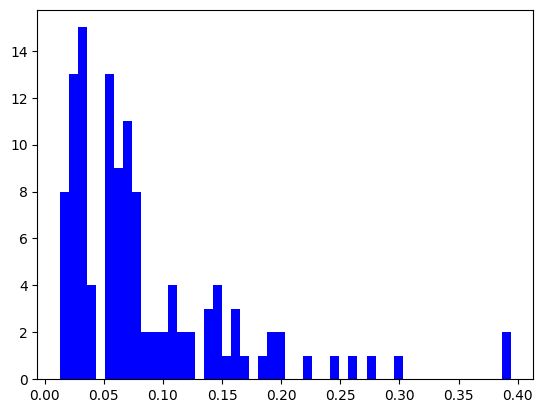

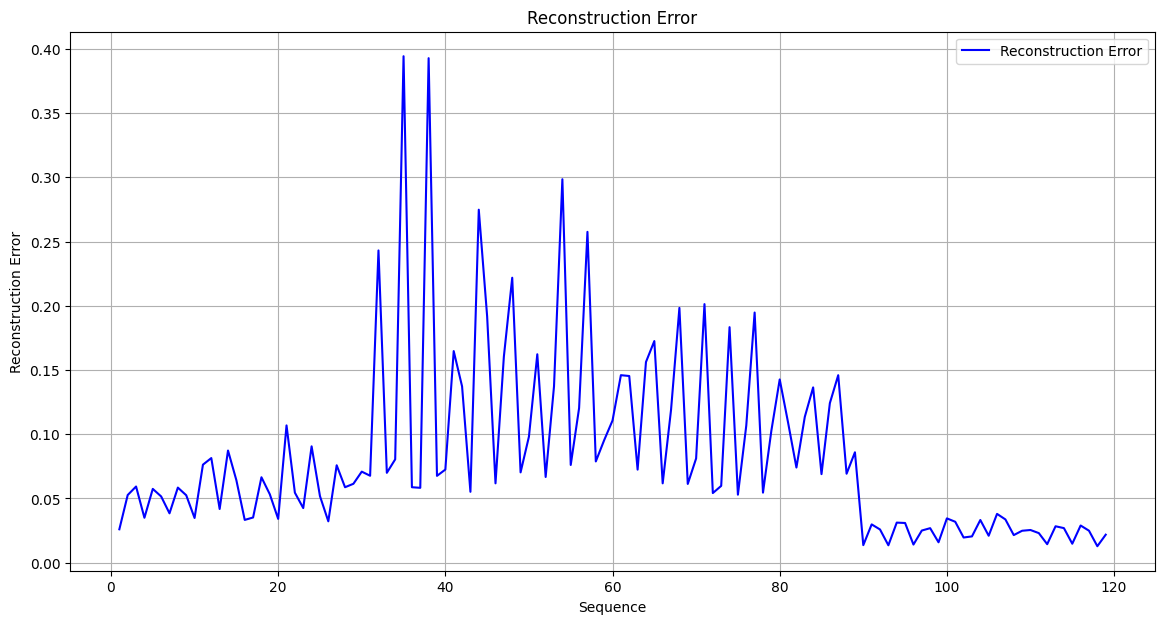

/tmp/ipykernel_2680664/315583813.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(files[1]))


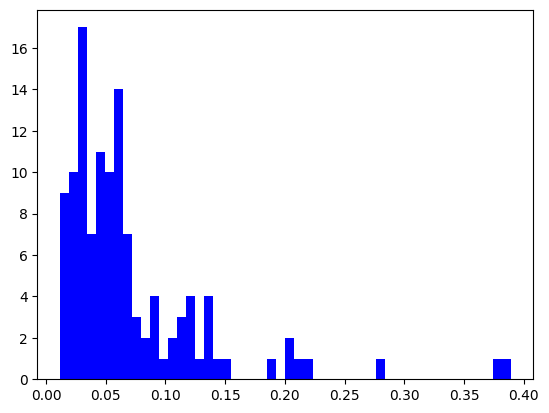

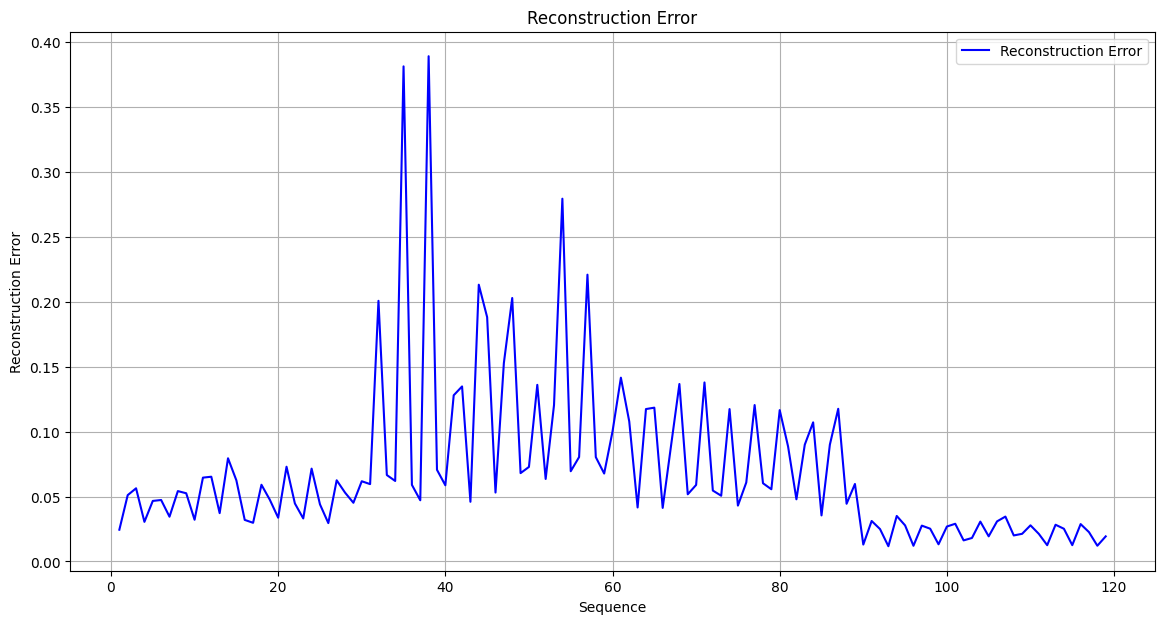

/tmp/ipykernel_2680664/315583813.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(files[2]))


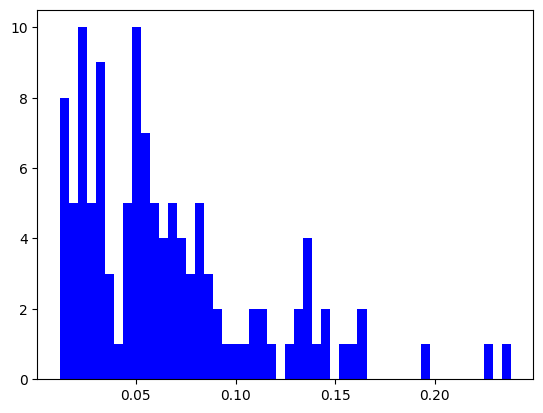

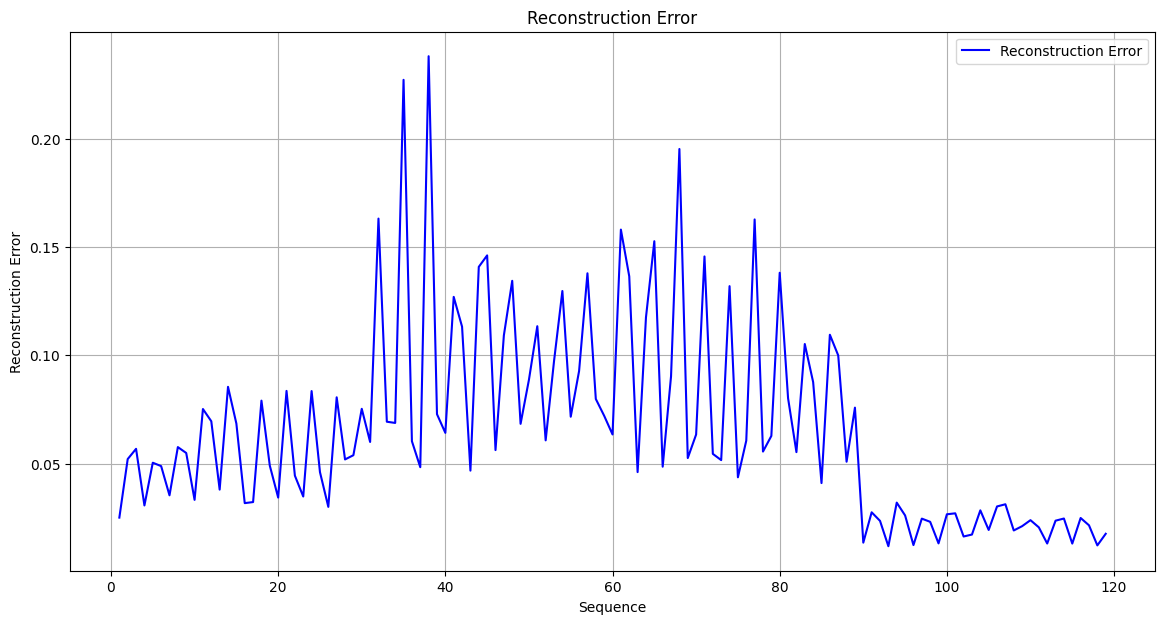

In [12]:
files = ["models/0_1_4.pth", "models/10_2_4.pth", "models/10_5_4.pth"]
model = LSTMAutoencoder(device, seq_len=100, n_features=4).to(device)

# Local, 4 Sensors
model.load_state_dict(torch.load(files[0]))
l_4 = evaluate(model, eval_dl)
# print("Local, 4 Sensors")
# print("Mean Reconstruction Loss: " + str(float(l_4[0])) + ". " + "Standard Deviation: " + str(float(l_4[1])))

# 2 Clients, 4 Sensors
model.load_state_dict(torch.load(files[1]))
two_4 = evaluate(model, eval_dl)
# print("2 Clients, 4 Sensors")
# print("Mean Reconstruction Loss: " + str(float(2_4[0])) + ". " + "Standard Deviation: " + str(float(val2_4[1])))

# 5 Clients, 4 Sensors
model.load_state_dict(torch.load(files[2]))
five_4 = evaluate(model, eval_dl)
# print("5 Clients, 4 Sensors")
# print("Mean Reconstruction Loss: " + str(float(5_4[0])) + ". " + "Standard Deviation: " + str(float(5_4[1])))



In [13]:
sensors = 8

dataframe = pd.read_csv("data/eval_data.csv", delimiter=';')
df = dataframe[['counter', 'dms1', 'dms2', 'dms3', 'dms4', 'dms5', 'dms6', 'dms7', 'dms8']]

df = df.groupby(df.index // 10).agg({
    'counter': 'first',
    'dms1': 'mean',
    'dms2': 'mean',
    'dms3': 'mean',
    'dms4': 'mean',
    'dms5': 'mean',
    'dms6': 'mean',
    'dms7': 'mean',
    'dms8': 'mean'
}).reset_index(drop=True)

df = df.iloc[1800:-1200]


print("Start: ", df['counter'].min())
print("End: ", df['counter'].max())

print(f"Shape of df after slicing: {df.shape}")

# approx 80/20 split
eval_data = 0.2
breakpoint = int(len(df) * eval_data)
eval = df.iloc[:breakpoint]

print(eval.shape)

scaler = StandardScaler()
dms_sensors = [f"dms{i}" for i in range(1, sensors + 1)]
scaler = scaler.fit(eval[dms_sensors])

eval[dms_sensors] = scaler.transform(eval[dms_sensors])

def to_sequences(x, seq_size=1):
    x_values = []
    y_values = []
    print('lenx: ', len(x))

    for i in range(len(x) - seq_size - offset):
        x_values.append(x.iloc[i:(i + seq_size)].values)
        y_values.append(x.iloc[i + offset:(i + offset + seq_size)].values)
    return np.array(x_values), np.array(y_values)

num_eval_seq = len(eval) - seq_size

# shape: (samples, seq_size, n_features)
# shape: (samples, seq_size, n_features)
evalX, evalY = [], []

for sensor in dms_sensors:
    evalX_tmp, evalY_tmp = to_sequences(eval[sensor], seq_size)
    evalX.append(evalX_tmp)
    evalY.append(evalY_tmp)

evalX = np.concatenate(evalX, axis=0).reshape(-1, seq_size, sensors)
evalY = np.concatenate(evalY, axis=0).reshape(-1, seq_size, sensors)

print('evalX shape:', evalX.shape)
print('evalY shape:', evalY.shape)

print(f"Number of test sequences: {num_eval_seq}")


# print(trainX.shape)
# print(trainY.shape)

evalX = torch.tensor(evalX, dtype=torch.float32)
evalY = torch.tensor(evalY, dtype=torch.float32)

eval_dataset = TensorDataset(evalX, evalY)

eval_dl = DataLoader(eval_dataset, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Start:  18000
End:  213070
Shape of df after slicing: (19508, 9)
(3901, 9)
lenx:  3901
lenx:  3901
lenx:  3901


/tmp/ipykernel_2680664/3846770834.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval[dms_sensors] = scaler.transform(eval[dms_sensors])


lenx:  3901
lenx:  3901
lenx:  3901
lenx:  3901
lenx:  3901
evalX shape: (3791, 100, 8)
evalY shape: (3791, 100, 8)
Number of test sequences: 3801


/tmp/ipykernel_2680664/1495597473.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(files[0]))


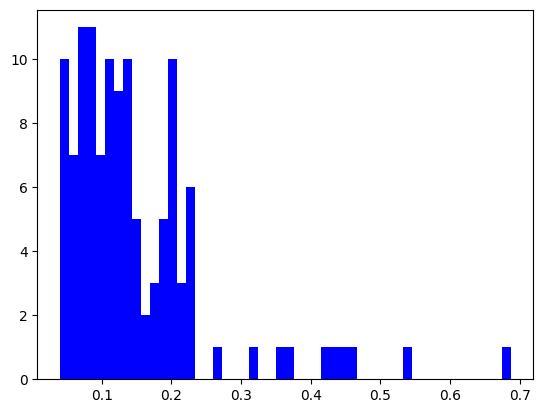

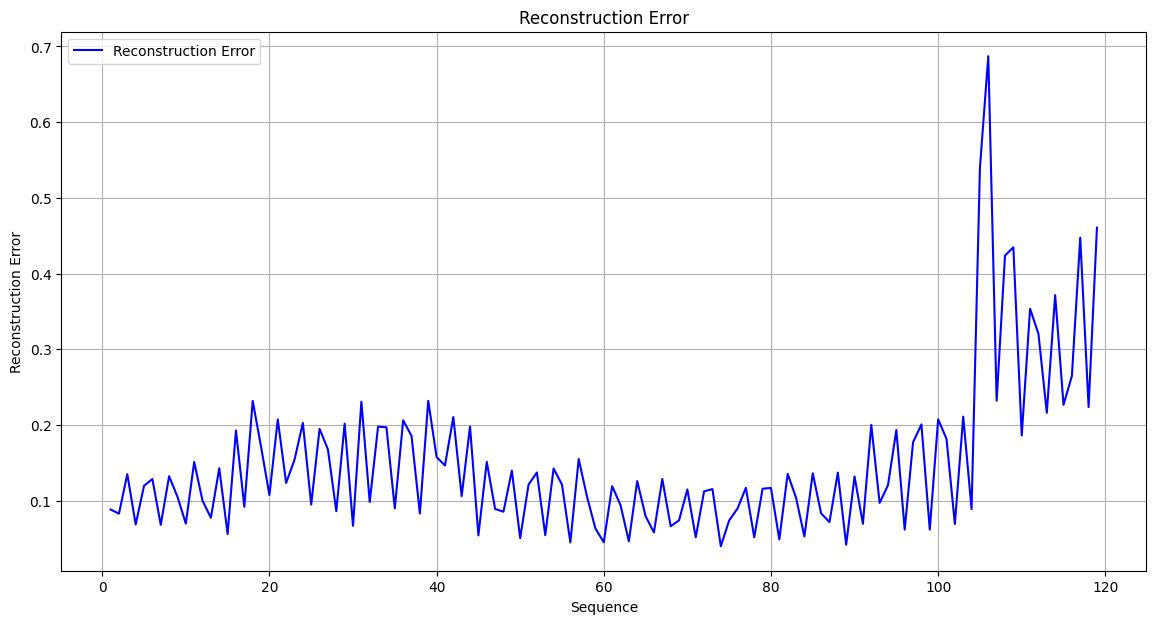

/tmp/ipykernel_2680664/1495597473.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(files[1]))


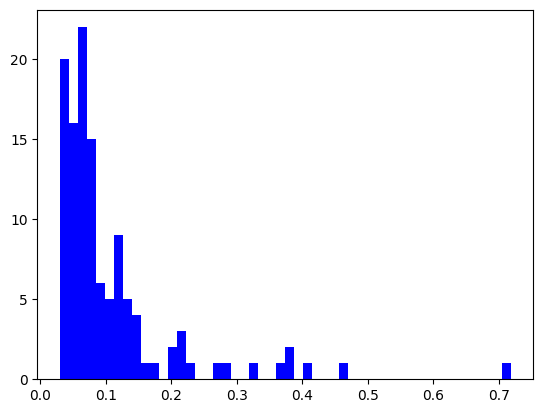

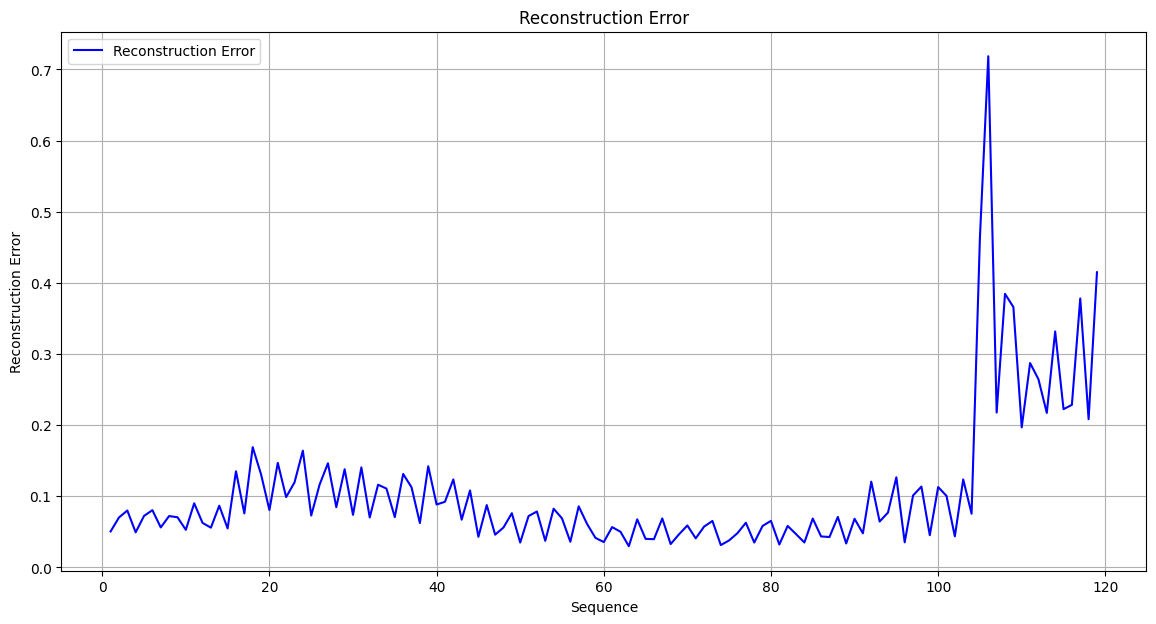

/tmp/ipykernel_2680664/1495597473.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(files[2]))


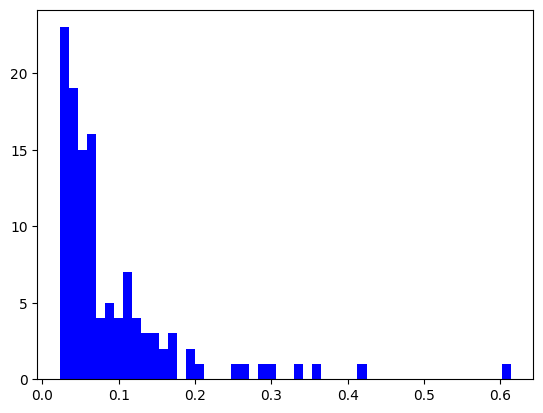

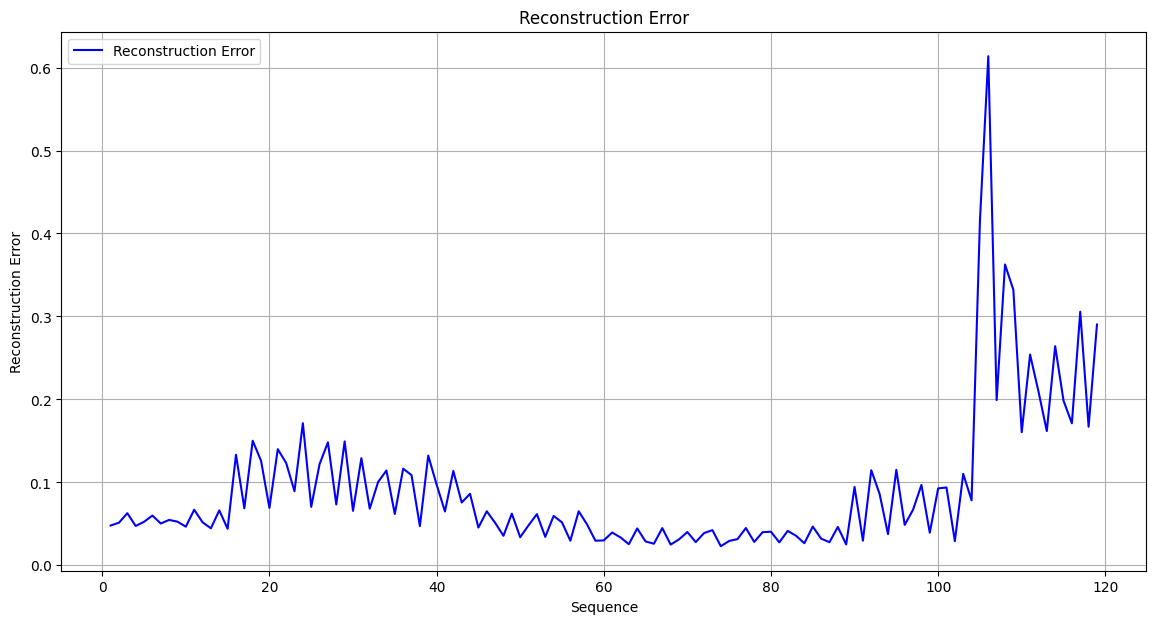

Local, 4 Sensors
Mean Reconstruction Loss: 0.08447669456642465. Standard Deviation: 0.0723749962888202
Local, 8 Sensors
Mean Reconstruction Loss: 0.14952119089224758. Standard Deviation: 0.10543789222642512
2 Clients, 4 Sensors
Mean Reconstruction Loss: 0.07073316690238084. Standard Deviation: 0.06394291754447592
2 Clients, 8 Sensors
Mean Reconstruction Loss: 0.10687654077255425. Standard Deviation: 0.10100783023248912
5 Clients, 4 Sensors
Mean Reconstruction Loss: 0.06665281387938171. Standard Deviation: 0.04627706167217699
5 Clients, 8 Sensors
Mean Reconstruction Loss: 0.09085011278756526. Standard Deviation: 0.08769811951441162


In [14]:
files = ["models/0_1_8.pth", "models/10_2_8.pth", "models/10_5_8.pth"]
model = LSTMAutoencoder(device, seq_len=100, n_features=8).to(device)

# Local, 8 Sensors
model.load_state_dict(torch.load(files[0]))
l_8 = evaluate(model, eval_dl)
# print("Local, 8 Sensors")
# print("Mean Reconstruction Loss: " + str(float(l_8[0])) + ". " + "Standard Deviation: " + str(float(l_8[1])))


# 2 Clients, 8 Sensors
model.load_state_dict(torch.load(files[1]))
two_8 = evaluate(model, eval_dl)
# print("2 Clients, 8 Sensors")
# print("Mean Reconstruction Loss: " + str(float(2_8[0])) + ". " + "Standard Deviation: " + str(float(2_8[1])))

# 5 Clients, 8 Sensors
model.load_state_dict(torch.load(files[2]))
five_8 = evaluate(model, eval_dl)
# print("5 Clients, 8 Sensors")
# print("Mean Reconstruction Loss: " + str(float(5_8[0])) + ". " + "Standard Deviation: " + str(float(5_8[1])))

print("Local, 4 Sensors")
print("Mean Reconstruction Loss: " + str(float(l_4[0])) + ". " + "Standard Deviation: " + str(float(l_4[1])))
print("Local, 8 Sensors")
print("Mean Reconstruction Loss: " + str(float(l_8[0])) + ". " + "Standard Deviation: " + str(float(l_8[1])))
print("2 Clients, 4 Sensors")
print("Mean Reconstruction Loss: " + str(float(two_4[0])) + ". " + "Standard Deviation: " + str(float(two_4[1])))
print("2 Clients, 8 Sensors")
print("Mean Reconstruction Loss: " + str(float(two_8[0])) + ". " + "Standard Deviation: " + str(float(two_8[1])))
print("5 Clients, 4 Sensors")
print("Mean Reconstruction Loss: " + str(float(five_4[0])) + ". " + "Standard Deviation: " + str(float(five_4[1])))
print("5 Clients, 8 Sensors")
print("Mean Reconstruction Loss: " + str(float(five_8[0])) + ". " + "Standard Deviation: " + str(float(five_8[1])))